In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

# Load Dataset

In [2]:
data = pd.read_csv('conversion_project.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


# Remove Outliers

In [6]:
data[data['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [7]:
data = data[data['age'] < 100]

# EDA

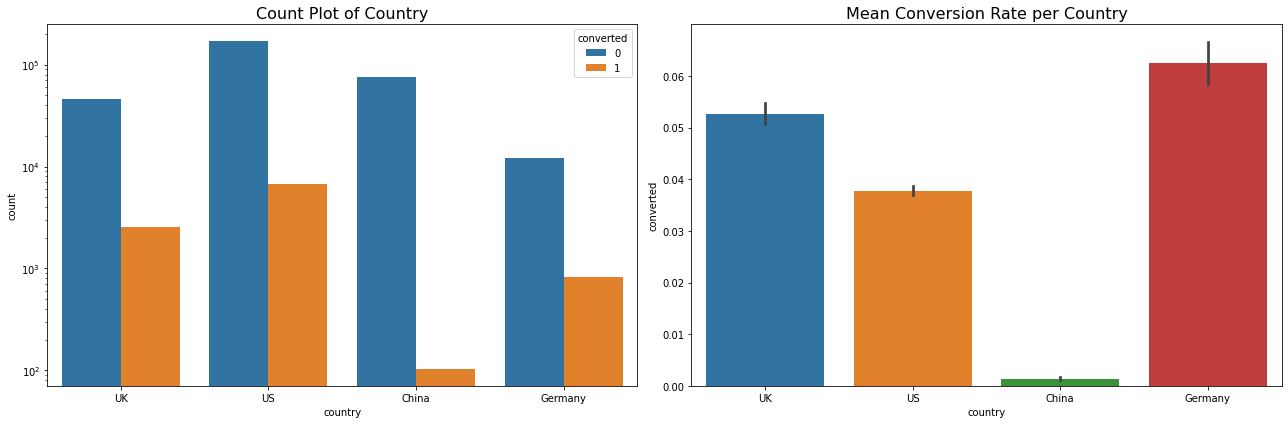

In [8]:
# Visualization of different countries

grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'country', hue = 'converted', data = data, ax = ax[0])
ax[0].set_title('Count Plot of Country', fontsize = 16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data = data, ax = ax[1])
ax[1].set_title('Mean Conversion Rate per Country',fontsize = 16)
plt.tight_layout()
plt.show()

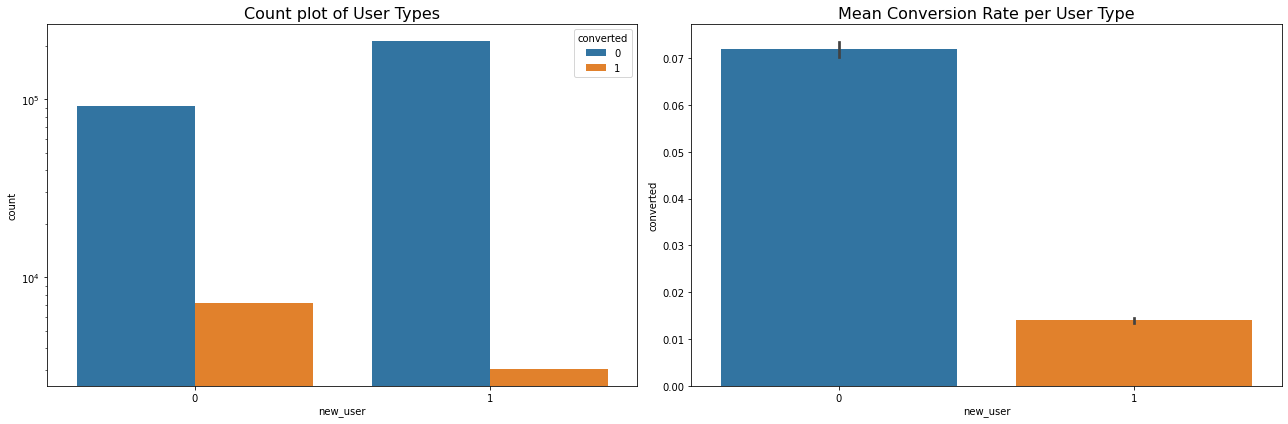

In [9]:
#Visualization of different user types
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'new_user', hue = 'converted', data = data, ax = ax[0])
ax[0].set_title('Count plot of User Types', fontsize = 16)
ax[0].set_yscale('log')
sns.barplot(x = 'new_user', y = 'converted', data = data, ax = ax[1])
ax[1].set_title('Mean Conversion Rate per User Type', fontsize = 16)
plt.tight_layout()
plt.show()

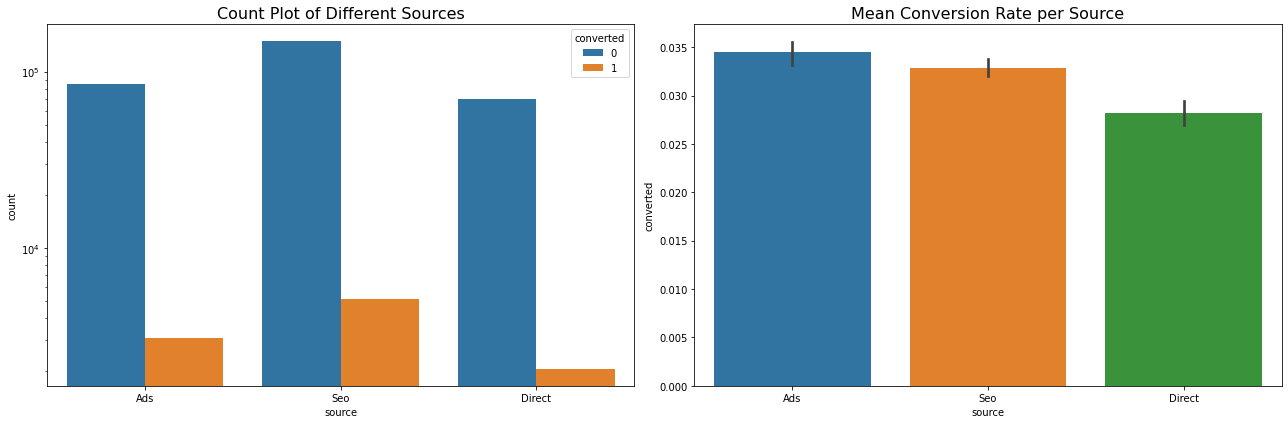

In [10]:
# Visualization of different sources
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'source', hue = 'converted', data = data, ax = ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize = 16)
ax[0].set_yscale('log')
sns.barplot(x = 'source', y='converted', data = data, ax = ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize = 16)
plt.tight_layout()
plt.show()

KeyError: 'total_pages_visited'

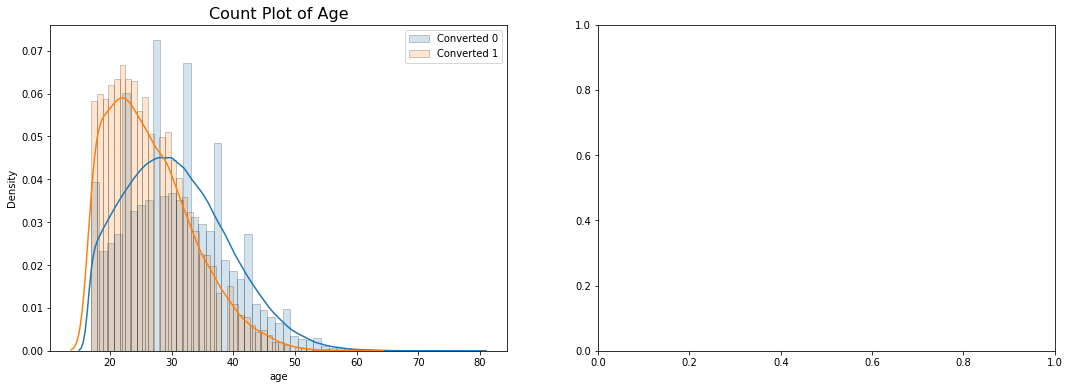

In [14]:
# Visualization of different sources

grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label = 'Converted 0', ax = ax[0], hist_kws = hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label = 'Converted 1', ax = ax[0], hist_kws = hist_kws)
ax[0].set_title('Count Plot of Age', fontsize = 16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize = 16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid(True)
plt.show()

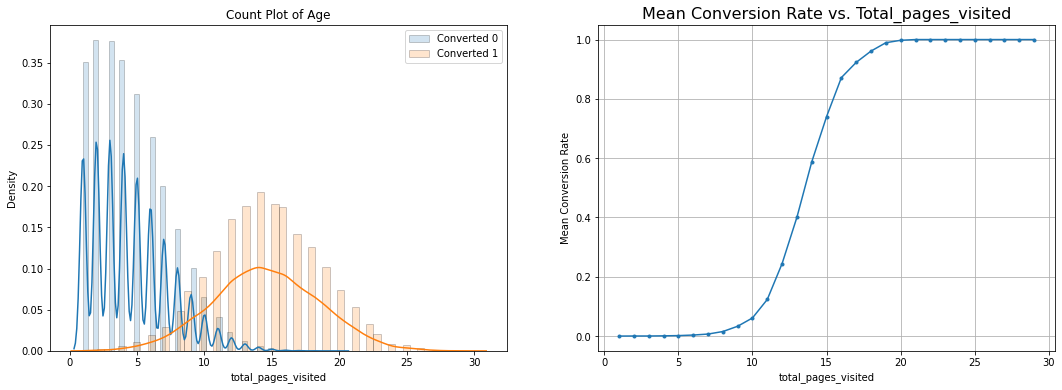

In [16]:
# Visualization of different sources
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], label = 'Converted 0', ax = ax[0], hist_kws = hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], label = 'Converted 1', ax = ax[0], hist_kws = hist_kws)
ax[0].set_title('Count Plot of Age')
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize = 16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid(True)
plt.show()

# Machine Learning

In [17]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04 LTS; OpenJDK Runtime Environment Zulu11.43+55-CA (build 11.0.9.1+1-LTS); OpenJDK 64-Bit Server VM Zulu11.43+55-CA (build 11.0.9.1+1-LTS, mixed mode)
  Starting server from /Users/zhouyi/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/4j/ry7_scw962q90x2629f31m2m0000gn/T/tmpmm68wg_i
  JVM stdout: /var/folders/4j/ry7_scw962q90x2629f31m2m0000gn/T/tmpmm68wg_i/h2o_zhouyi_started_from_python.out
  JVM stderr: /var/folders/4j/ry7_scw962q90x2629f31m2m0000gn/T/tmpmm68wg_i/h2o_zhouyi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_zhouyi_tu5ebz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [18]:
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [20]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac = 0.25, seed = 42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country','age','new_user','source','total_pages_visited']
target = 'converted'

In [21]:
# Build random forest model

model = H2ORandomForestEstimator(balance_classes = True, ntrees = 100, max_depth = 20,
                                 mtries = -1, seed = 42, score_each_iteration = True)
model.train(x = feature, y = target, training_frame = train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1652418070296_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,3204084.0,19.0,20.0,19.99,1677.0,2989.0,2542.26




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11846613631537281
RMSE: 0.3441890996463613
LogLoss: 0.3764399306371099
Mean Per-Class Error: 0.04077296202014859
AUC: 0.9928548908904044
AUCPR: 0.9916492588930318
Gini: 0.9857097817808087

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02780413173063362: 


,,0,1,Error,Rate
0,0,216822.0,12678.0,0.0552,(12678.0/229500.0)
1,1,6037.0,223471.0,0.0263,(6037.0/229508.0)
2,Total,222859.0,236149.0,0.0408,(18715.0/459008.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.027804,0.959809,378.0
1,max f2,0.009691,0.977572,389.0
2,max f0point5,0.086539,0.961980,352.0
3,max accuracy,0.029233,0.959253,377.0
4,max precision,0.990718,0.999493,6.0
5,max recall,0.002731,1.000000,394.0
6,max specificity,0.999482,0.999996,0.0
7,max absolute_mcc,0.027804,0.918839,378.0
8,max min_per_class_accuracy,0.045286,0.957705,370.0
9,max mean_per_class_accuracy,0.029233,0.959253,377.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.94 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010009,0.994843,1.998224,1.998224,0.999129,0.997562,0.999129,0.997562,0.019999,0.019999,99.822377,99.822377,0.019982
1,2,0.020002,0.990664,1.999529,1.998876,0.999782,0.992752,0.999455,0.995159,0.019982,0.039981,99.952914,99.887596,0.039959
2,3,0.030004,0.985929,1.997787,1.998513,0.998911,0.988318,0.999274,0.992878,0.019982,0.059963,99.778701,99.851295,0.059919
3,4,0.040001,0.981420,1.998658,1.998549,0.999346,0.983642,0.999292,0.990570,0.019982,0.079945,99.865769,99.854912,0.079888
4,5,0.050001,0.976922,1.998222,1.998484,0.999129,0.979207,0.999259,0.988297,0.019982,0.099927,99.822225,99.848375,0.099853
5,6,0.100000,0.935962,1.995434,1.996959,0.997734,0.960204,0.998497,0.974251,0.099770,0.199697,99.543363,99.695872,0.199396
6,7,0.150002,0.863700,1.992297,1.995405,0.996166,0.900773,0.997720,0.949758,0.099617,0.299314,99.229677,99.540472,0.298630
7,8,0.200001,0.801698,1.993168,1.994846,0.996601,0.831617,0.997440,0.920223,0.099657,0.398971,99.316788,99.484552,0.397947
8,9,0.300001,0.616559,1.987242,1.992311,0.993638,0.713458,0.996173,0.851302,0.198725,0.597696,98.724233,99.231112,0.595400
9,10,0.400000,0.303393,1.948201,1.981284,0.974118,0.475744,0.990659,0.757414,0.194817,0.792513,94.820134,98.128386,0.785040




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-05-12 22:08:20,0.088 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-05-12 22:08:22,1.487 sec,1.0,0.316211,0.358851,0.991199,0.988308,1.988731,0.043874
2,,2022-05-12 22:08:23,2.982 sec,2.0,0.315923,0.358017,0.991358,0.988704,1.989658,0.043747
3,,2022-05-12 22:08:24,3.976 sec,3.0,0.331386,0.372971,0.991143,0.988601,1.990518,0.043622
4,,2022-05-12 22:08:25,4.486 sec,4.0,0.328849,0.368511,0.991337,0.988699,1.989966,0.043300
5,,2022-05-12 22:08:25,5.039 sec,5.0,0.328026,0.363573,0.991643,0.989295,1.991139,0.042841
6,,2022-05-12 22:08:25,5.386 sec,6.0,0.327149,0.358592,0.991882,0.989684,1.991853,0.042374
7,,2022-05-12 22:08:26,5.757 sec,7.0,0.326228,0.355259,0.992030,0.989917,1.992218,0.042207
8,,2022-05-12 22:08:26,6.182 sec,8.0,0.325296,0.351689,0.992170,0.990130,1.992543,0.041991
9,,2022-05-12 22:08:27,6.584 sec,9.0,0.326282,0.353722,0.992189,0.990138,1.992415,0.041755



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,total_pages_visited,6.009332e+06,1.000000,0.769353
1,new_user,8.379513e+05,0.139442,0.107280
2,country,5.249283e+05,0.087352,0.067205
3,age,3.664189e+05,0.060975,0.046911
4,source,7.226071e+04,0.012025,0.009251


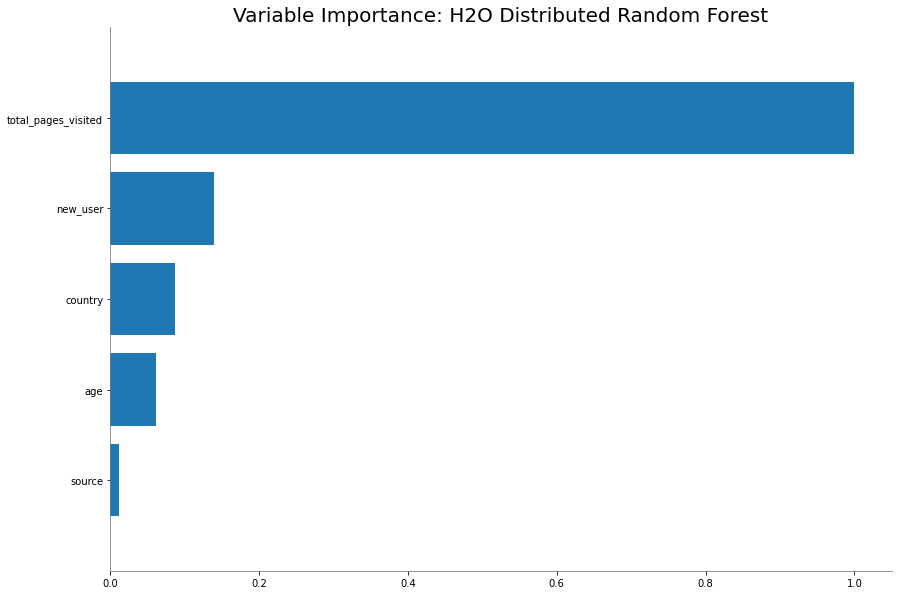

<Figure size 432x288 with 0 Axes>

In [22]:
model.varimp_plot()

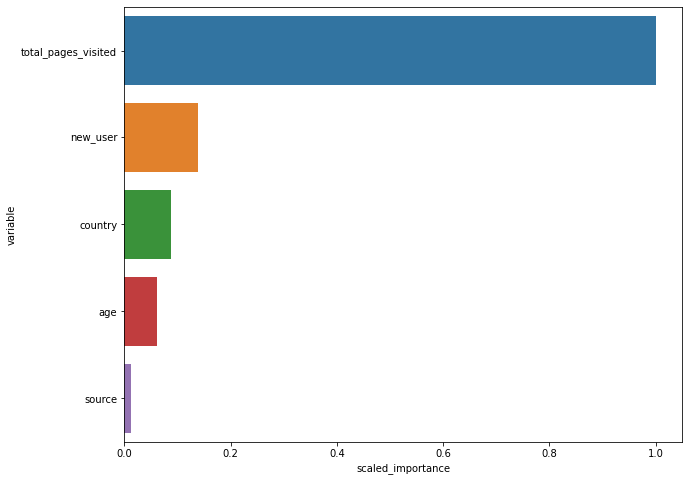

In [23]:
# Feature importance

importance = model.varimp(use_pandas = True)

fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(x = 'scaled_importance', y='variable', data = importance)
plt.show()

In [24]:
# Make Predictions 

train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [25]:
# classification report

print(classification_report(y_true = test_true, y_pred = (test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.84      0.63      0.72      2550

    accuracy                           0.98     79050
   macro avg       0.91      0.81      0.86     79050
weighted avg       0.98      0.98      0.98     79050



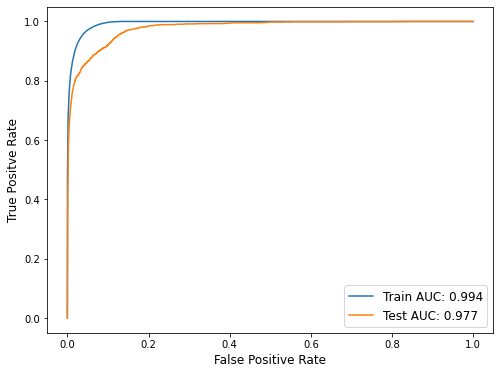

In [26]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(train_fpr, train_tpr, label = 'Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label = 'Test AUC: '+str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize = 12)
ax.set_ylabel('True Positve Rate', fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


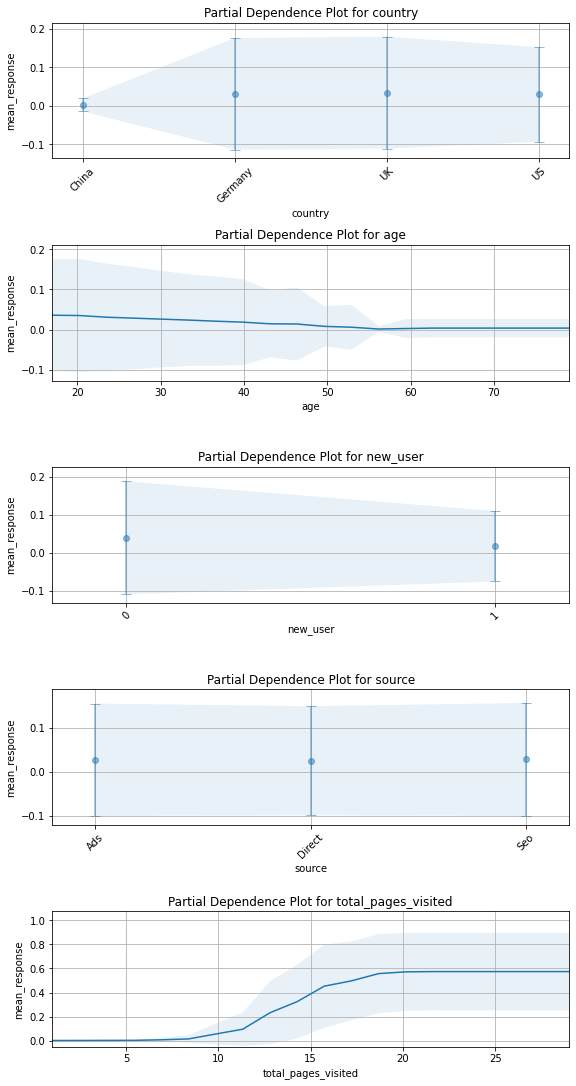

In [27]:
_ = model.partial_plot(train, cols = feature, figsize = (8,15))

In [28]:
h2o.cluster().shutdown()

H2O session _sid_8a40 closed.
